# Computer vision

- Image analysis and computer vision have always been important in industrial and scientific appications. With the popularization of cell phones with powerful cameras and Internet connections, images now are increasingly generated by consumers. Therefore, there are opportunities to make use of computer vision to provide a better user experience in new contexts.

- In this chapter, we will look at how to apply techniques you have learned in the rest of this book to this specific type of data. In particular, we will learn how to use the mahots computer vision package to extract features from images. These features can be used as input to the same classification methods we studied in other chapters. We also see how the same features can be used on another problem, that is, the problem of finding similar looking images. 


- Finally, at the end ofthis chapter, we will learn about using local features. These are relatively new methods (the first of these methods to achieve state-of-the-art performance, the scale-invariant feature transform(SIFT), was introduced in 1999) and achieve very good results in many tasks.

## Introducing image processing

- From the point of view of the computer, an image is a large rectangular array of pixel values. Our goal is to process this image and to arrive at a decision for our application.

- The first step will be to load the image from disk, where it is typically stored in an image-specific format such as PNG or JPEG, the former being a lossless compression format, and the latter a lossy compression one that is optimized for visual assessment of phtographs. Then, we may wish to perform preprocessing on the images (for example, normalizing them for illumination variations).

- We will have a classification problem as a driver for this chapter. We want to be able to learn a support vector machine (or other) classifier that can be trained from images. Therefore, we will use an intermediate representation, extracting numeric features from the images before applying machine learning.

## Loading and displaying images 

- In order to manipulate images, we will use a package called mahotas. 

In [33]:
import mahotas as mh

In [34]:
image = mh.imread('scene00.jpg')

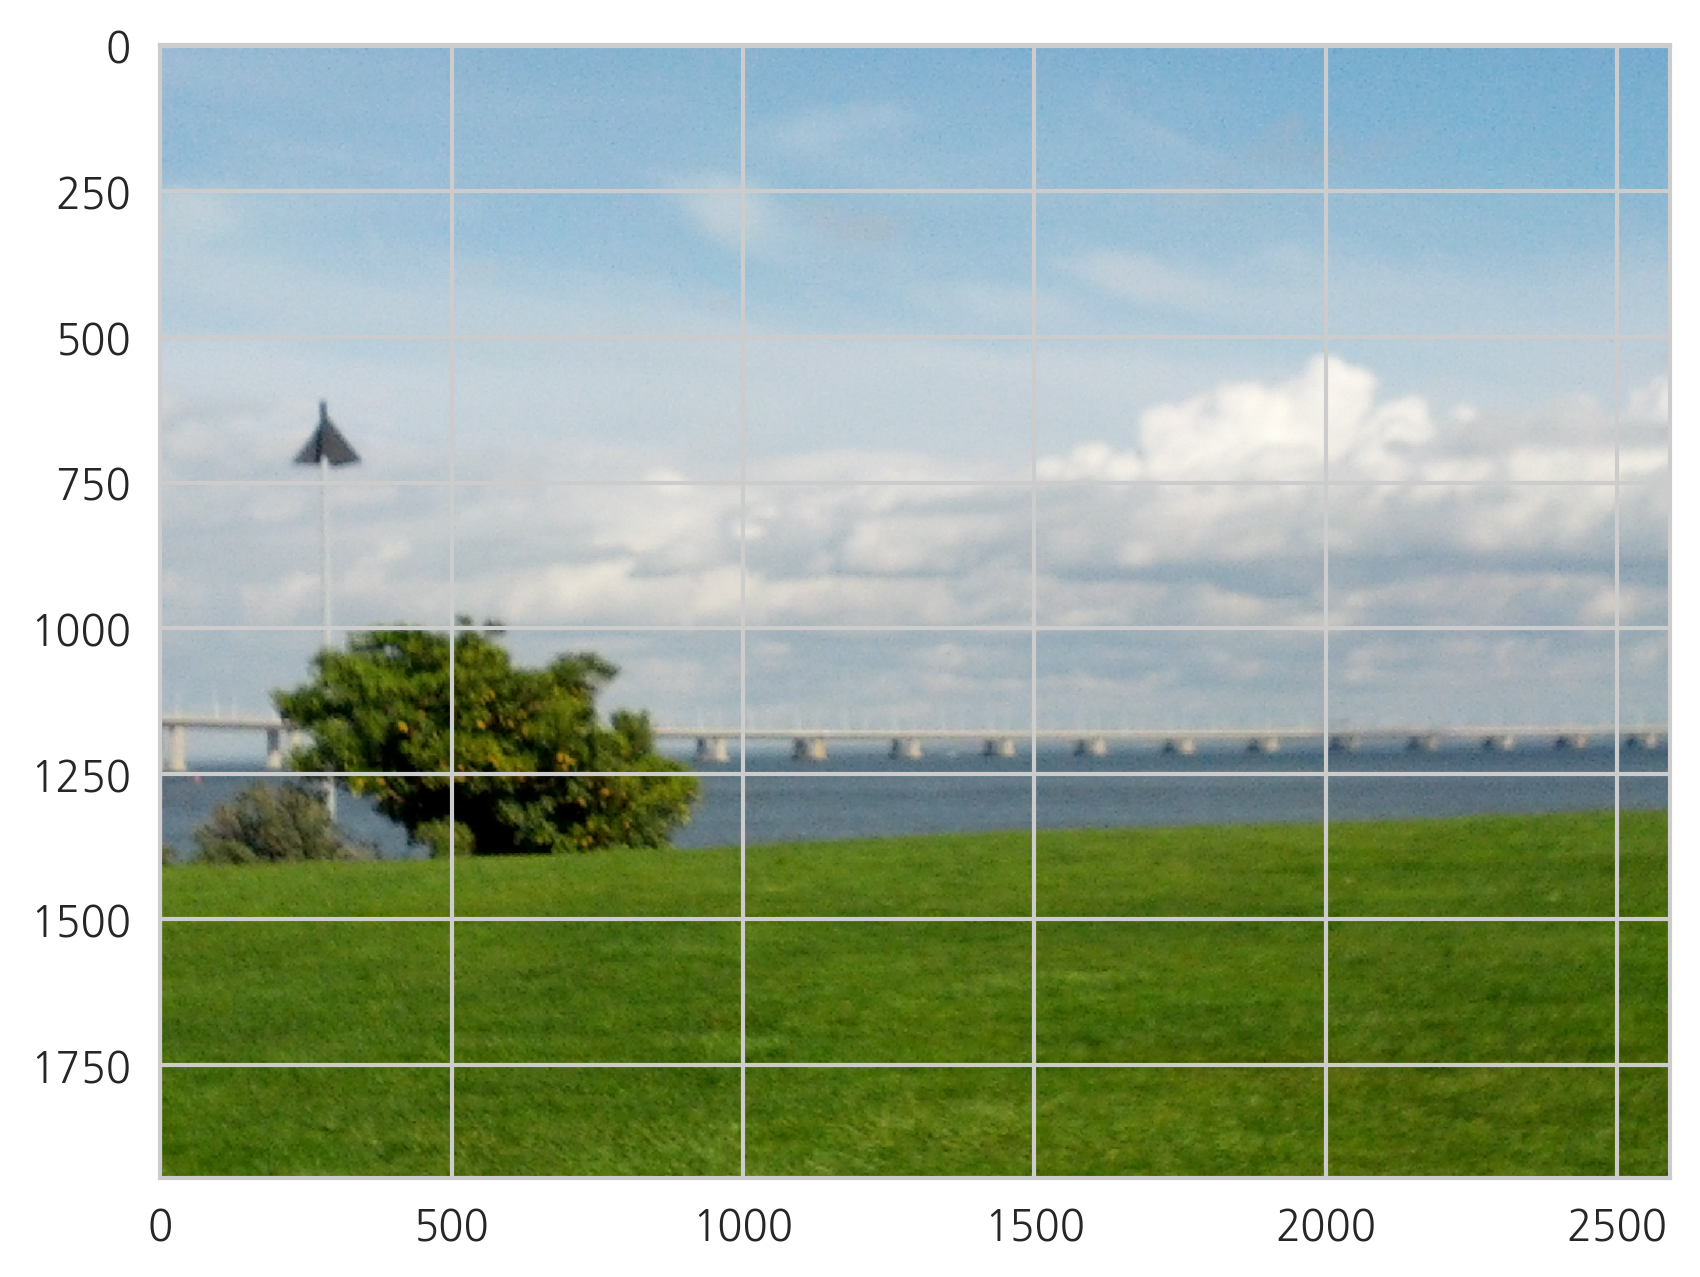

In [35]:
plt.imshow(image)

In [36]:
image.shape # height, width, rgb

(1944, 2592, 3)

- Other system put the width in the first dimension, but this it the convention that is used by all NumPy-based packages. The type of the array will typically be np.uint8 (an unsigned 8-bit integer). These are the images that your camera takes or that your monitor can fully display.

- Some specialized equipment, used in scientific and technical applications, can take images with higher bit resolution (that is, with more sensitivity to small variations in brightness). Twelbve or sixteen bits are common in this type of equipment. Mahotas can deal with all these types, including floating point images. In many computations, even if the original data is composed of unsigned integers, it is advantageous to convert to floating point numbers in order to simplify handling of rounding and overflow issues.

- We can display the image on screen using matplotlib, the plotting library we have already used several times, as follows:

In [37]:
from matplotlib import pyplot as plt

## Thresholding

- Thresholding is a very simple operation: we transform all pixel values above a certain threshold to 1 and all those below it to 0 (or by using Booleans, transform it to True and False). The important question in thresholding is to select a good value to use as the threshold limit. Mahotas implements a few methods for choosing a threshold value from the image. One is called Otsu, after its invertor. The first necessary step is to convert the image to grayscale, with rgb2gray in the mahotas color submodule.

- Instead of rgb2gray, we could also have just the mean value of the red, green, and blue channels, by calling image.mean(2). The result, however, would not be the same, as rgb2gray uses different weights for the different colors to give a subjectively more pleasing result. Our eyes are not equallt sensitive to the three basic colors.

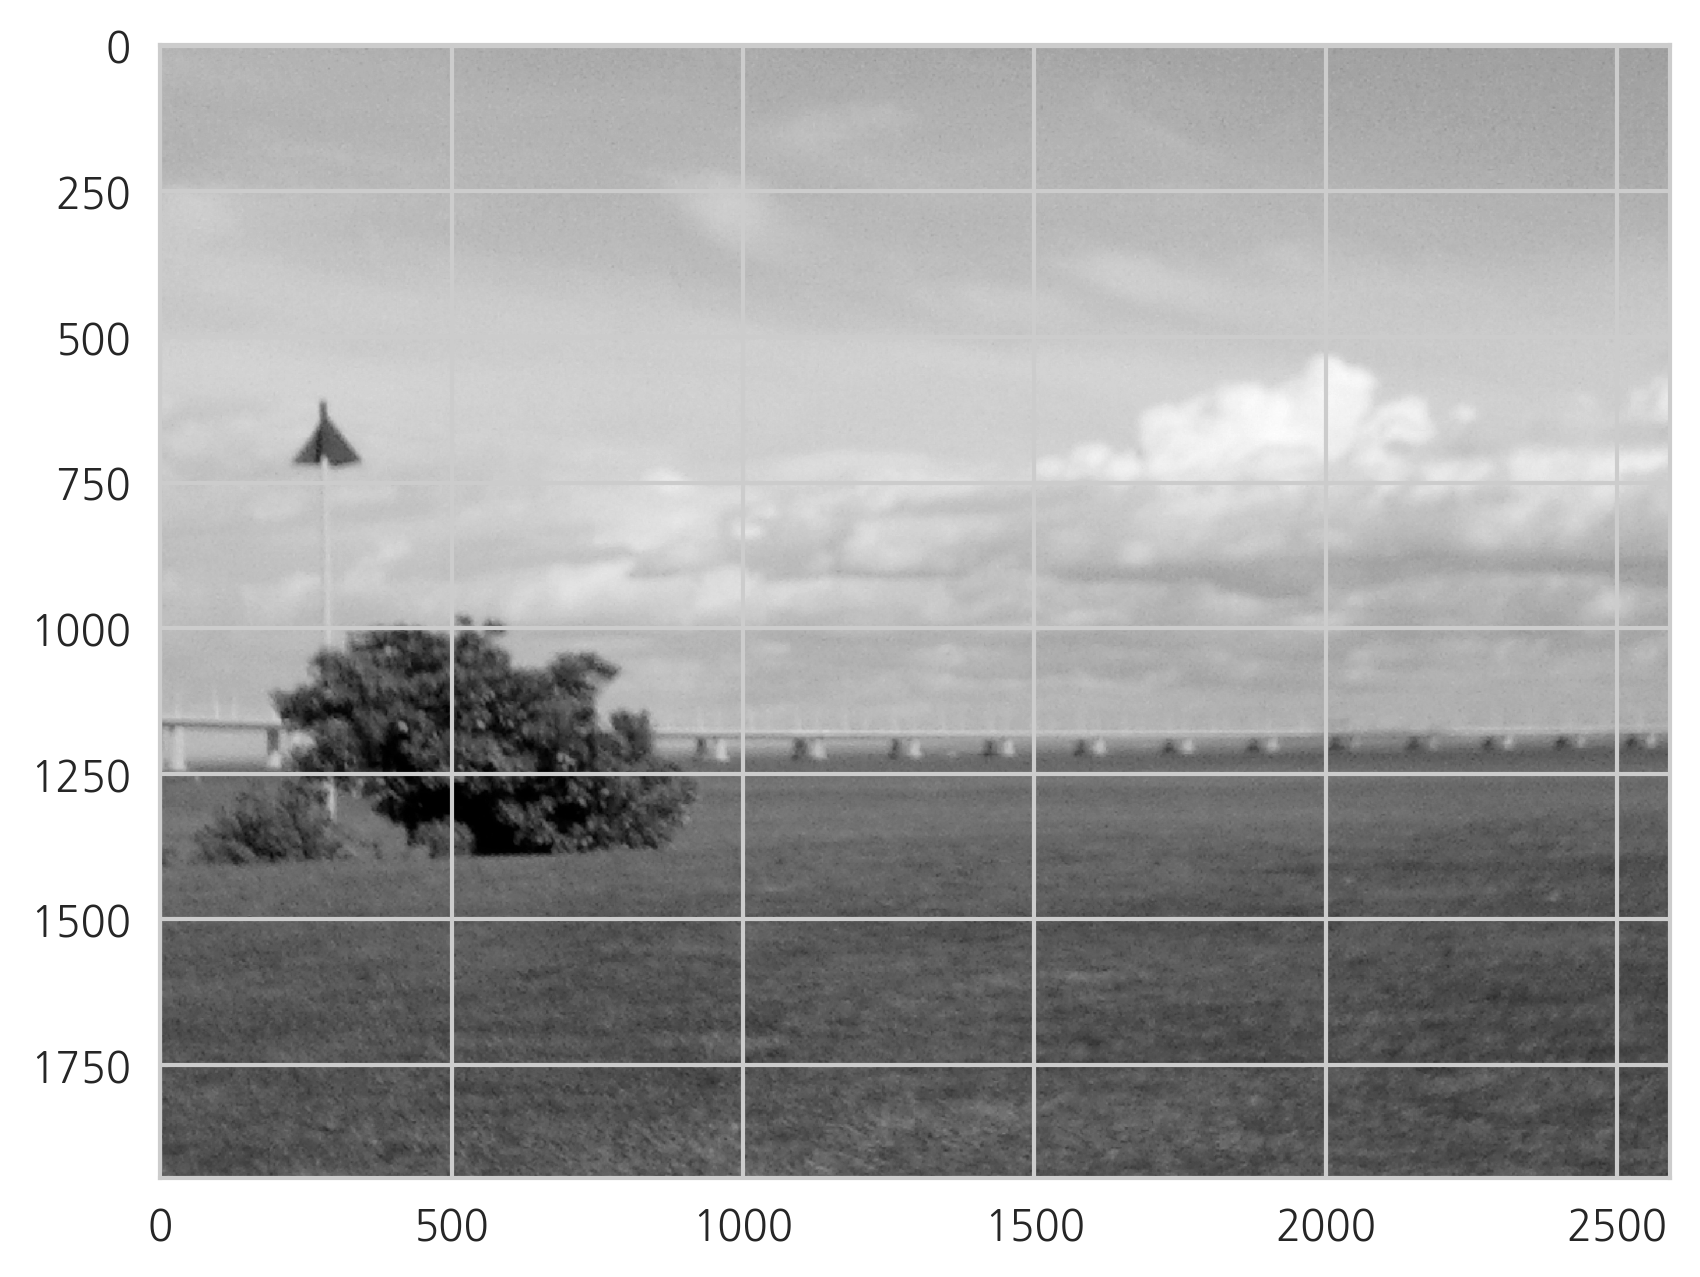

In [38]:
image = mh.colors.rgb2grey(image, dtype=np.uint8)
plt.imshow(image)
plt.gray()

- By default, matplotlib will display this single-channel image as a false color image , using red for high values and blue for low values. For natural images, a grayscale is more appropriate. You can select it with:

- Now the image is shown in gray scale. Note that only the way in which the pixel values are interpreted and shown has changed and the image data is untouched. We can continue our processing by computing the threshold value:

In [39]:
thresh = mh.thresholding.otsu(image)
print('Otsu threshold is {}'.format(thresh))

Otsu threshold is 138


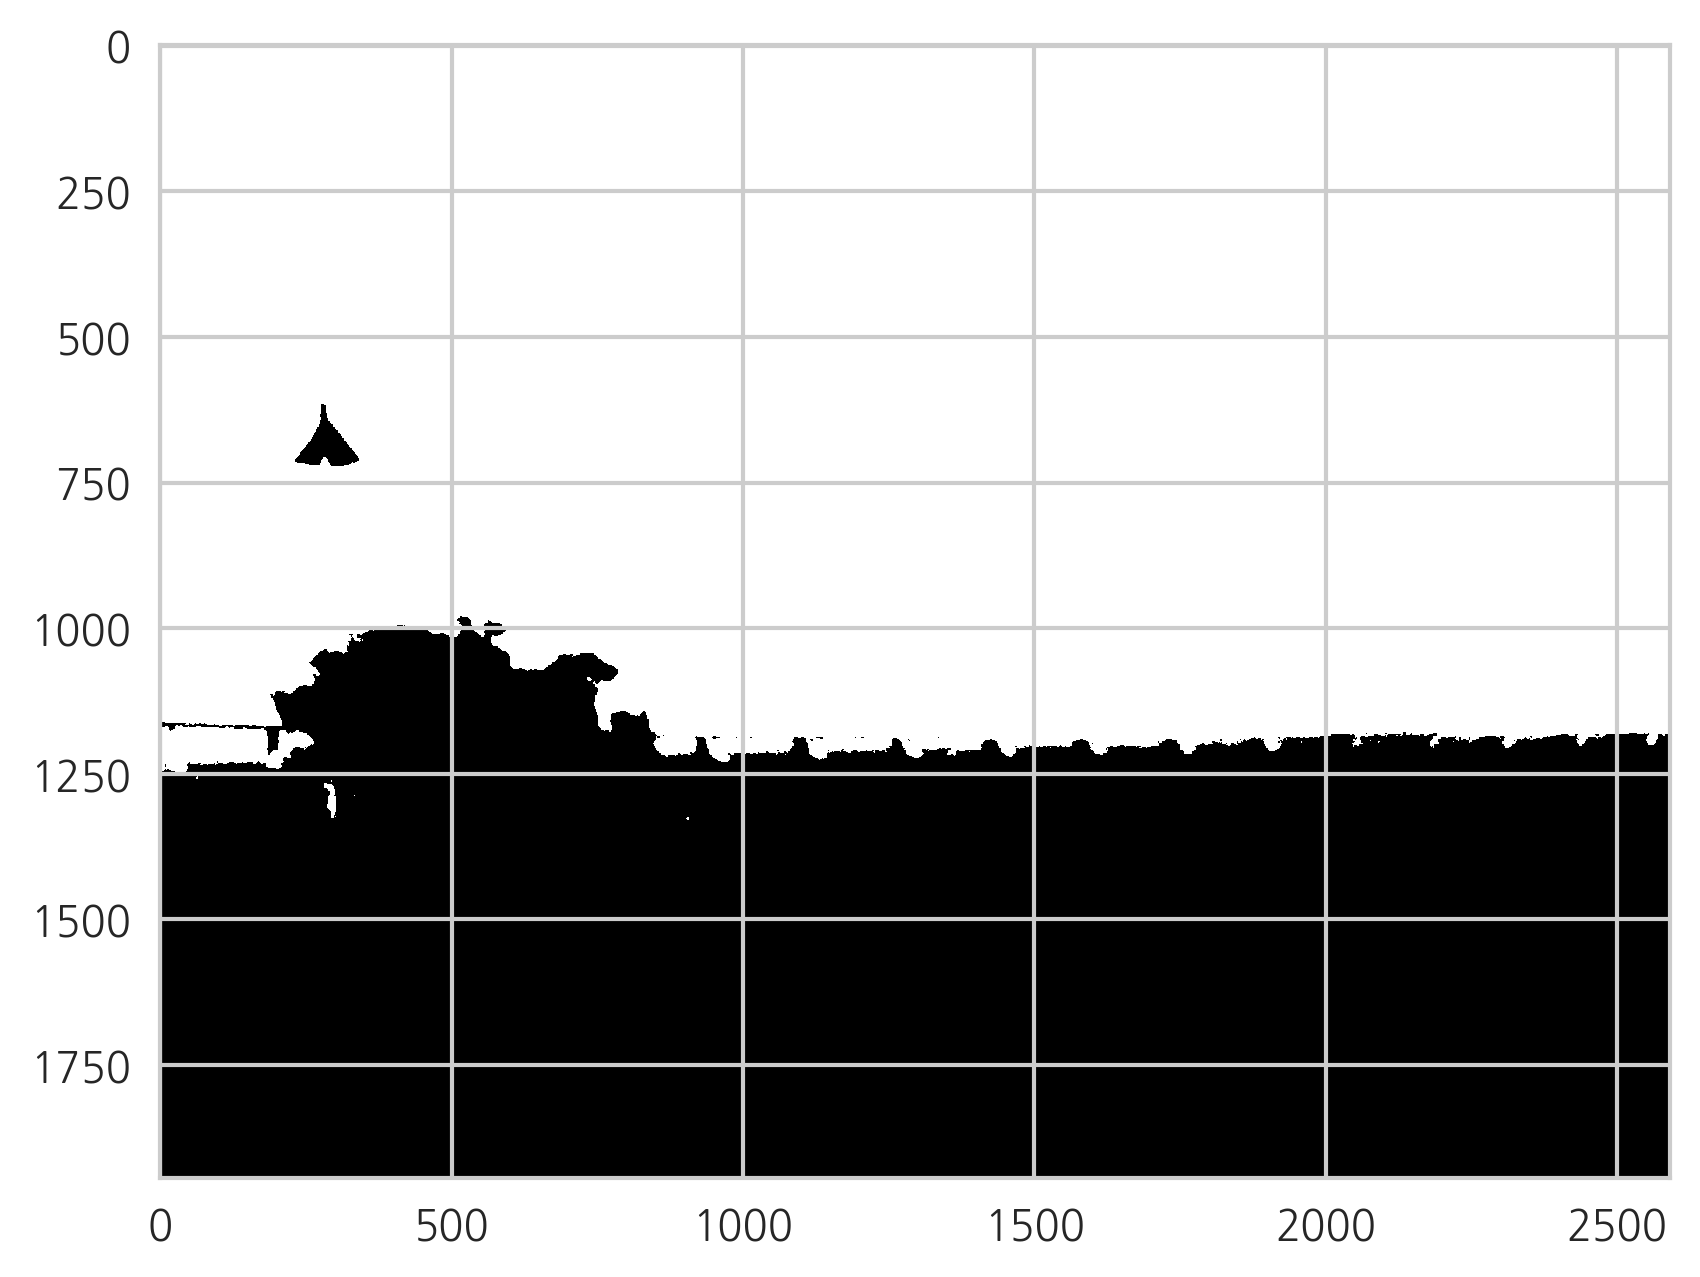

In [40]:
plt.imshow(image > thresh)

## Gaussian blurring

- Blurring your image may seem odd, but it often serves to reduce noise, which helps with further processing. With mahotas, it is just a function call:

In [41]:
im16 = mh.gaussian_filter(image, 16)

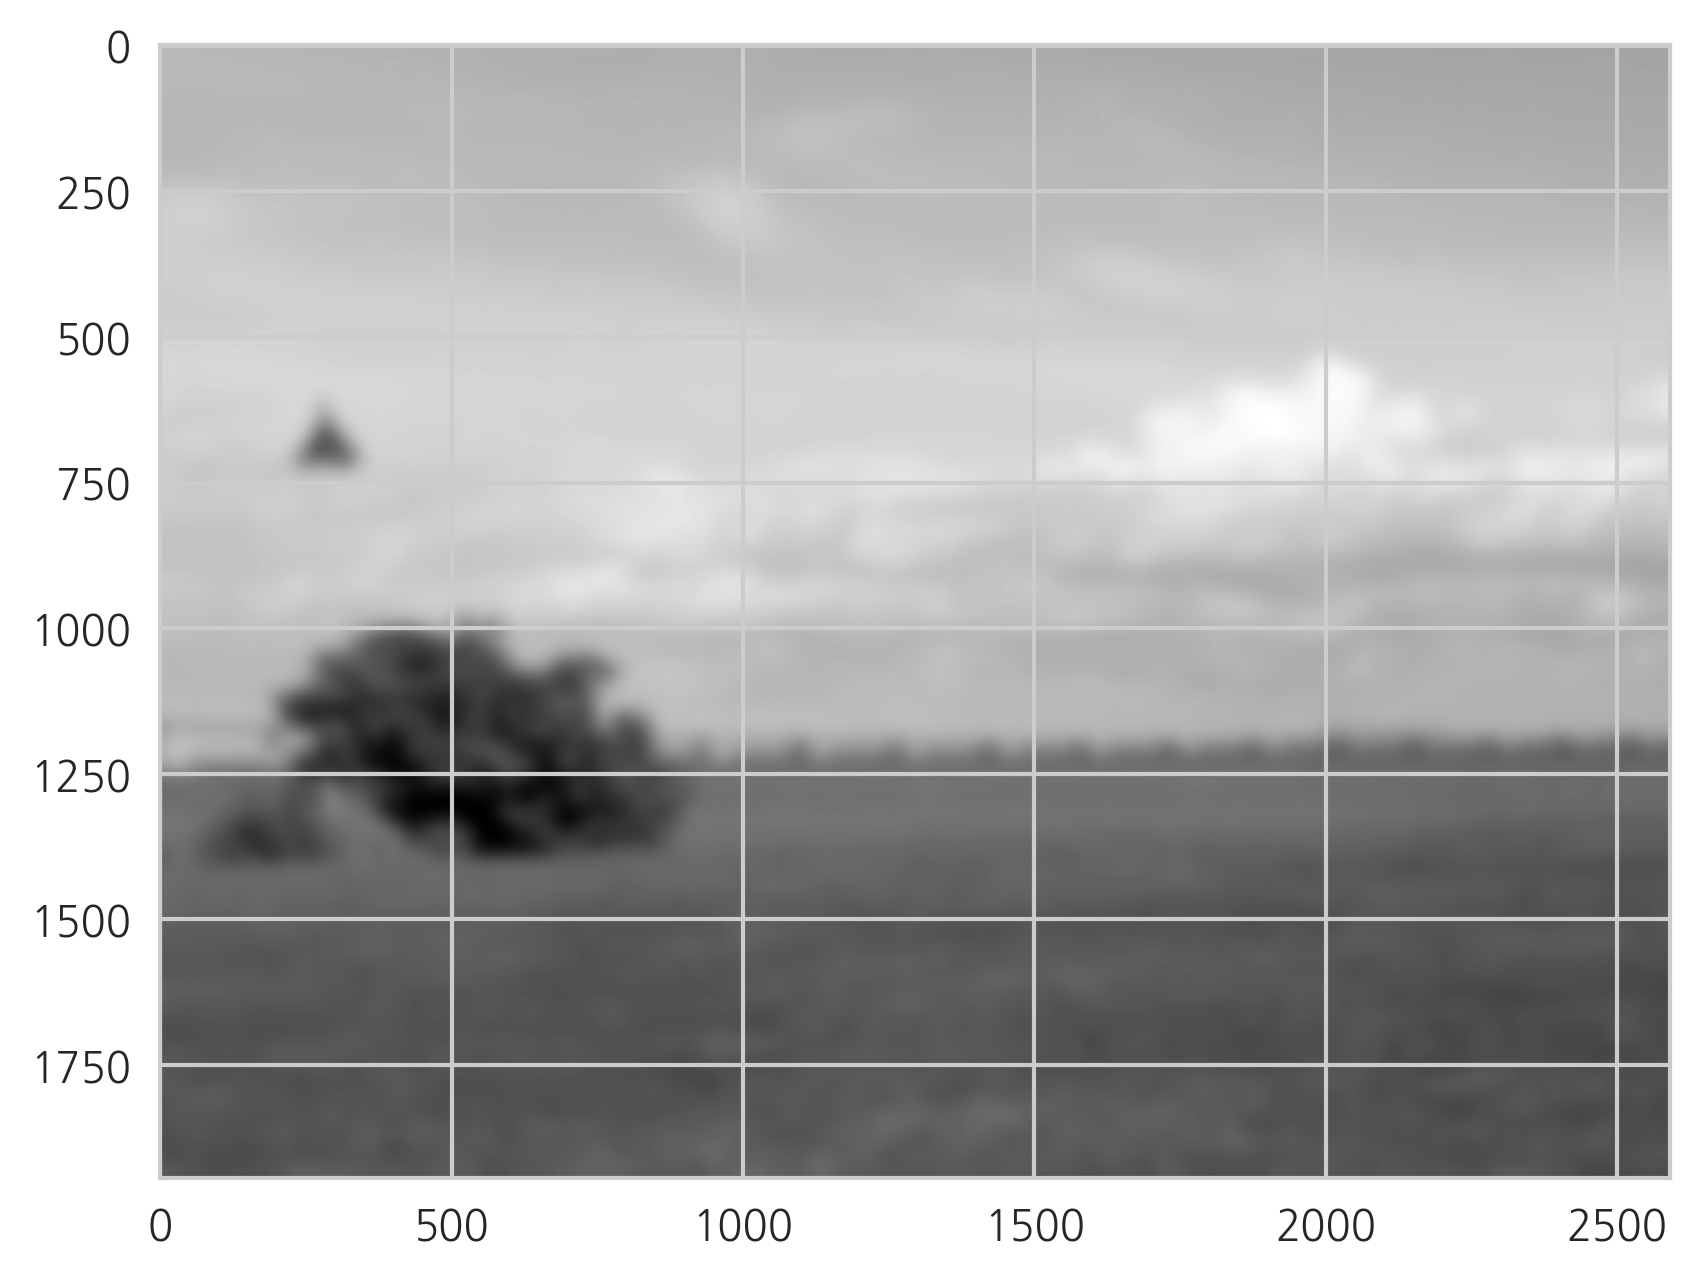

In [42]:
plt.imshow(im16)

- Notice that we did not convert the grayscale image to unsigned integers: we just made use of the floating point result as it is. The second argument to the gaussian\_filter function is the size of the filter (the standard deviation of the filter). Larger values result in more blurring, as shown in the following screenshot:

- We can use the screenshot on the left and threshold with Otsu (using the same previous code). Now, the boundaries are smoother, without the jagged edges, as shown in the following screenshot:

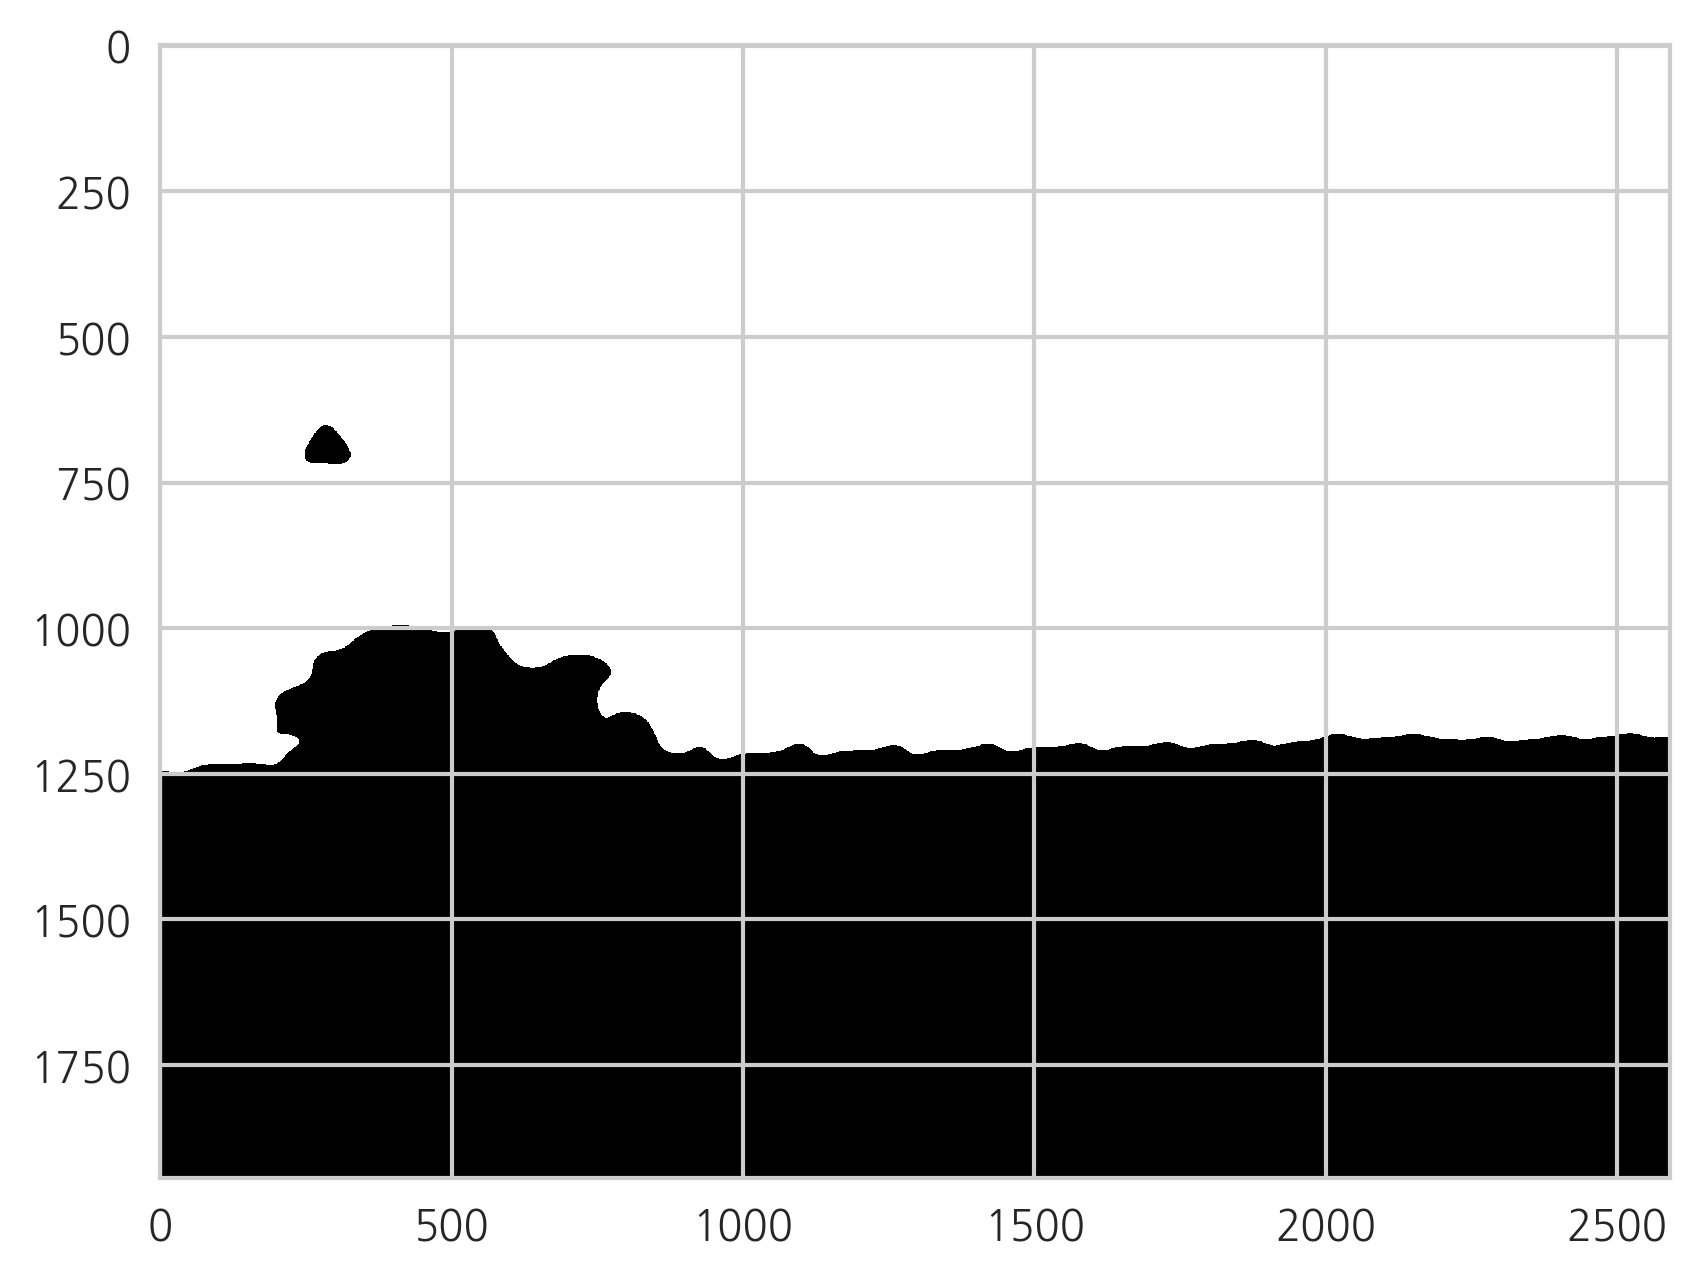

In [43]:
plt.imshow(im16 > thresh)

## Putting the center in focus

- The final example shows how to mix NumPy operators with a tiny bit of filtering to get an interesting result. We start with the Lena image and split it into the color channels:

In [58]:
im = mh.demos.load('lena')

- To split the red, green, and blue channels, we use the following code:

In [44]:
im.shape

(512, 512, 3)

In [45]:
r, g, b = im.transpose(2, 0, 1)

In [46]:
r.shape

(512, 512)

- Now, we filter the three channels separately and build a composite image out of it with mh.as_rgb. This function takes three two-dimensional arrays, performs contrast stretching to make each be an 8-bit integer array, and then stacks them, returning a color RGB image:

In [47]:
r12 = mh.gaussian_filter(r, 12.)
g12 = mh.gaussian_filter(g, 12.)
b12 = mh.gaussian_filter(b, 12.)
im12 = mh.as_rgb(r12, g12, b12)

In [48]:
im12.shape

(512, 512, 3)

- Now, we blend the two images from the center away to the edges. First, we need to build a weights array W, which will contain at each pixel a normalized value, which is its distance to the center:

In [49]:
h, w = r.shape
Y, X = np.mgrid[:h, :w]

In [50]:
print(Y.shape)
print(X.shape)

(512, 512)
(512, 512)


- We used the np.mgrid object, which returns arrays of size (h, w), with values correstponding to the y and x coordinates, respectively.

In [51]:
Y = Y - h/2.
Y = Y / Y.max()

In [52]:
X = X - w/2.
X = X / X.max()

In [53]:
C = np.exp(-2. * (X**2 + Y**2))

In [54]:
C = C - C.min()
C = C / C.ptp()
C = C[:,:,None]

In [55]:
X

array([[-1.00392157, -1.        , -0.99607843, ...,  0.99215686,
         0.99607843,  1.        ],
       [-1.00392157, -1.        , -0.99607843, ...,  0.99215686,
         0.99607843,  1.        ],
       [-1.00392157, -1.        , -0.99607843, ...,  0.99215686,
         0.99607843,  1.        ],
       ..., 
       [-1.00392157, -1.        , -0.99607843, ...,  0.99215686,
         0.99607843,  1.        ],
       [-1.00392157, -1.        , -0.99607843, ...,  0.99215686,
         0.99607843,  1.        ],
       [-1.00392157, -1.        , -0.99607843, ...,  0.99215686,
         0.99607843,  1.        ]])

- Notice how all of these manipulations are performed using NumPy arrays and not some mahotas-specific methodology. Finally, we can combine the two images to have the center be in sharp focus and the edges softer:

In [56]:
ringed = mh.stretch(im*C + (1-C)*im12)

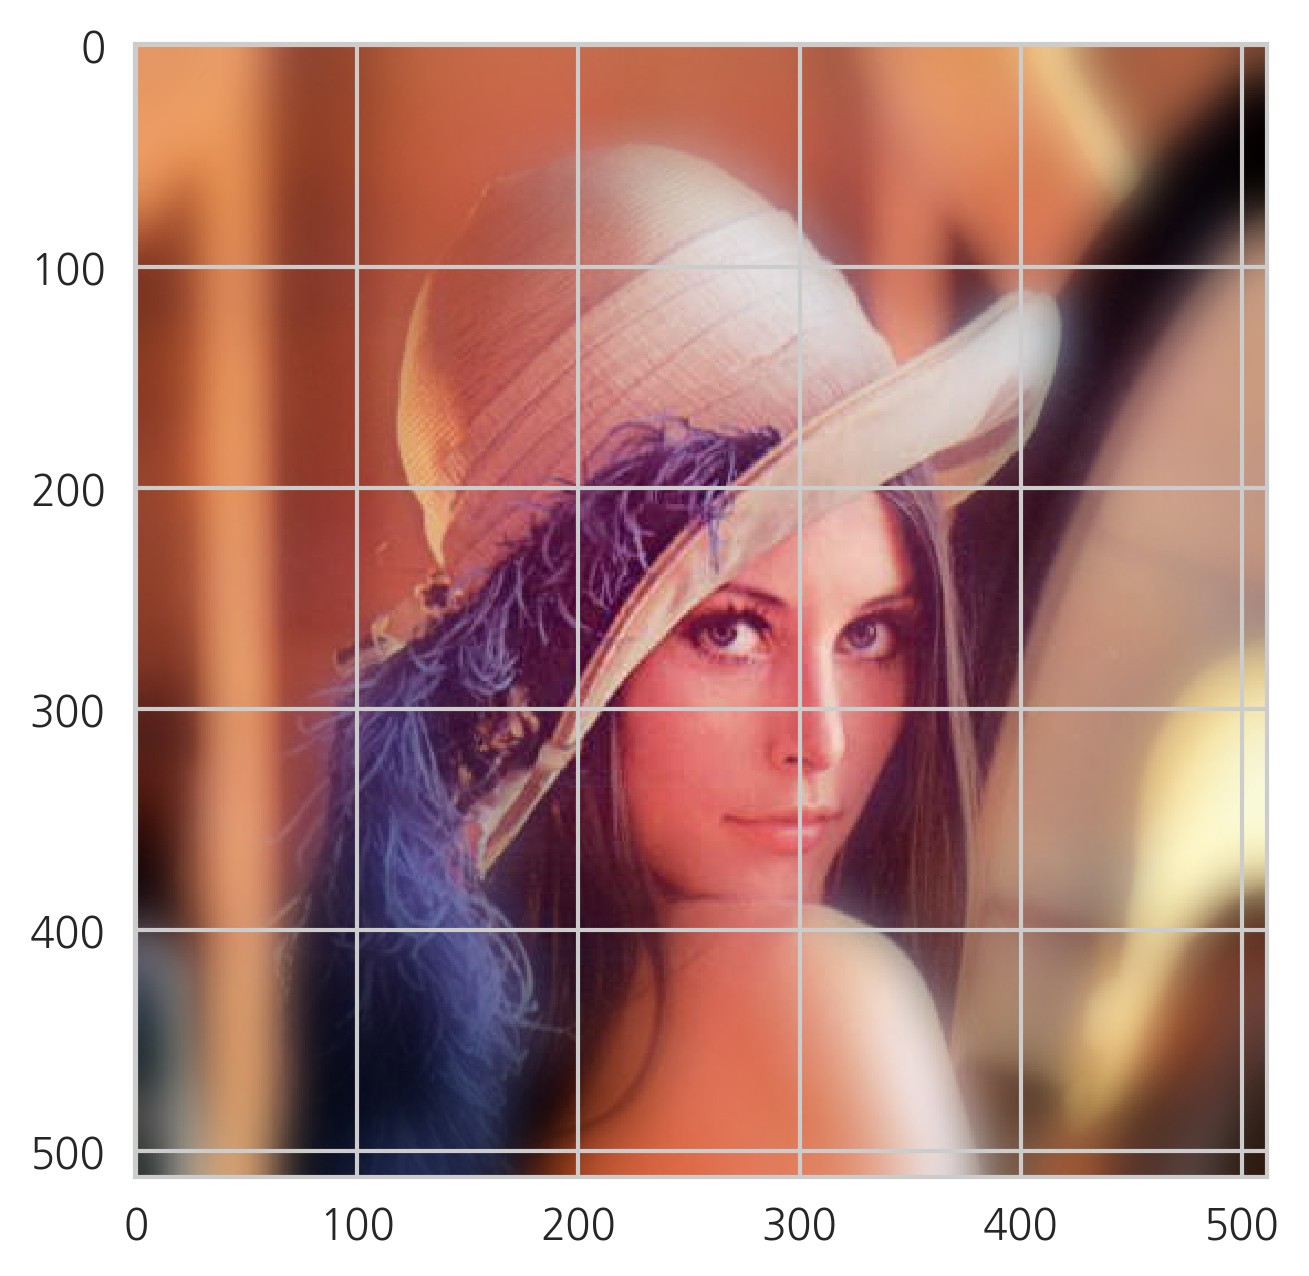

In [57]:
plt.imshow(ringed)

## Basic image classification

- We will start with a small dataset that was collected especially for this book. It has three classes: buildings, natural scenes (landscapes), and pictures of texts. There are 30 images in each category, and they were all taken using a cell phone camera with minimal composition. The images are similar to those that would be uploaded to a modern website by users with no photography training. This dataset is available from this book's website or the GitHub code repository. Later in this chapter, we will look at a harder dataset with more images and more categories.

- When classifying images, we start with a large rectangular array of numbers (pixel values). Nowadays, millions of pixels are common. We could try to feed all these numbers as features into the learning algorithm. This is not a very good idea. This is because the relationship of each pixel (or even each small group of pixels) to the final result is very indirect. Also, having millions of pixles, but only as a small number of example images, results in a very hard statistical learning problem. This is an extreme form of the P greater than N type of problem we discussed CH7. Instead, a good approach is to compute features from the image and use those features for classification.

- Having said that, I will point out that, in fact, there are a few methods that do work directly from the pixel values. They have feature submodules inside them. They may even attempt to learn good features automatically. These methods are the topic of current research. They typically work best with very large datasets.

- We previously used an example of the scene class. The following are examples of the text and building classes:

** P 250 **